# Prerequisites

In [2]:
!pip install --upgrade pip
!pip install -r requirements.txt


# Dataset generation

In [3]:
import numpy as np

# Function to generate synthetic temperature data
def generate_temperature_data(min_temp, max_temp, num_samples, random=False):
    """
    Generate temperature data for a given range and number of samples.
    Converts Fahrenheit to Celsius as part of data generation.
    
    Args:
        min_temp (int): Minimum temperature in Fahrenheit.
        max_temp (int): Maximum temperature in Fahrenheit.
        num_samples (int): Number of samples to generate.
        random (bool): If True, samples are generated randomly; otherwise, they are linearly spaced.

    Returns:
        np.array: An array of shape (num_samples, 2) with Fahrenheit and Celsius values.
    """
    if random:
        fahrenheit = np.random.uniform(min_temp, max_temp, num_samples)
    else:
        fahrenheit = np.linspace(min_temp, max_temp, num_samples)
    celsius = (fahrenheit - 32) * 5.0 / 9.0
    return np.vstack([fahrenheit, celsius]).T


# Model training and validation

In [4]:
from datetime import datetime

def get_unique_name(prefix):
    """
    Generates a unique name for a layer based on the current date and time.
    This ensures that each created layer name is distinctive, which can be helpful 
    for debugging or tracking layer creation times in logs.

    Args:
        prefix (str): The prefix to use for the name, which helps identify the layer type,
                      such as 'dense', 'dropout', or 'conv'. This prefix provides context
                      for the layer's purpose or functionality.

    Returns:
        str: A uniquely generated name combining the provided prefix and the current 
             timestamp. Format: 'prefix_YYYYMMDD_HHMMSS_microseconds'.
    """
    # Get the current time in a specific format including microseconds for uniqueness
    current_time = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
    
    # Return the combined string of prefix and timestamp to ensure uniqueness
    return f"{prefix}_{current_time}"


In [5]:
!pip3 install tf_keras matplotlib

In [6]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tf_keras as keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


# Generate and print temperature data
data = generate_temperature_data(-100, 212, 1000, random=True)
print("\nGenerated temperature data (Fahrenheit, Celsius):")
print(data)

# Create DataFrame from the temperature data
fahrenheit = data[:, 0]  # All rows, first column
celsius = data[:, 1]     # All rows, second column
df = pd.DataFrame({
    'Celsius': celsius,
    'Fahrenheit': fahrenheit
})

# Save dataset in CSV
df.to_csv('celsiusFahrenheit.csv')

# Split data into 80% training and 20% testing, then split training for 5% validation
X_train_test, X_val, y_train_test, y_val = train_test_split(df[['Celsius']], df['Fahrenheit'], test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.05, random_state=42)

keras.backend.clear_session()  # Clear any previous session

# Constructing a simple neural network for regression
hidden_layer_1 = keras.layers.Dense(units=3, input_shape=[1], name=get_unique_name('hidden_layer_1'))
hidden_layer_2 = keras.layers.Dense(units=3, name=get_unique_name('hidden_layer_2'))
output_layer = keras.layers.Dense(units=1, name=get_unique_name('output_layer'))
model = keras.Sequential([
    hidden_layer_1,
    hidden_layer_2,
    output_layer
])

optimizer = keras.optimizers.legacy.Adam(learning_rate=0.1)  # Set learning rate here
model.compile(optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model quietly
history = model.fit(X_train, y_train, epochs=300, validation_data=(X_test, y_test), verbose=False)



Generated temperature data (Fahrenheit, Celsius):
[[-33.96893767 -36.64940982]
 [-75.22739527 -59.57077515]
 [-18.72877658 -28.18265366]
 ...
 [ -8.60763539 -22.55979744]
 [  8.4115041  -13.10471994]
 [-75.40471256 -59.66928476]]


# Metrics

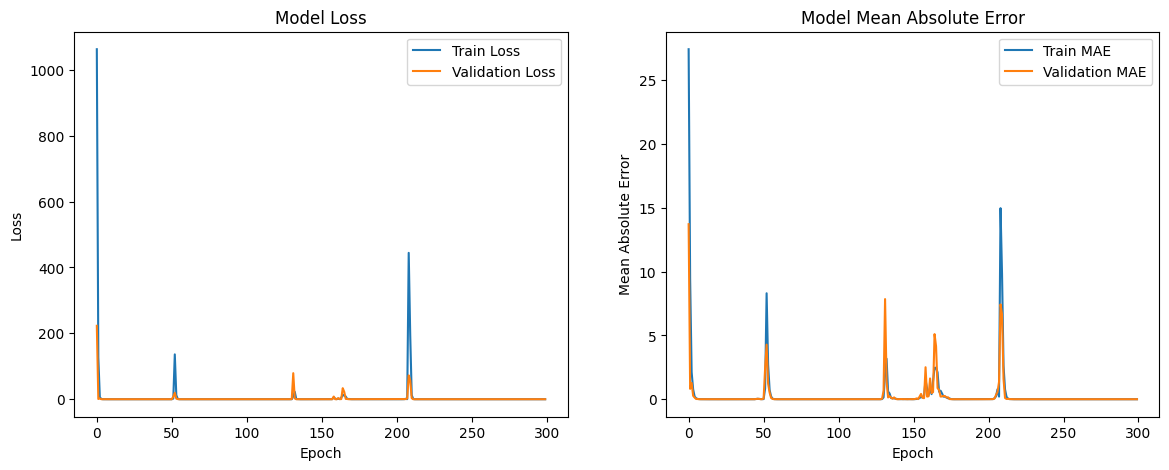

Let's make a prediction!
7/7 [==============================] - 0s 482us/step


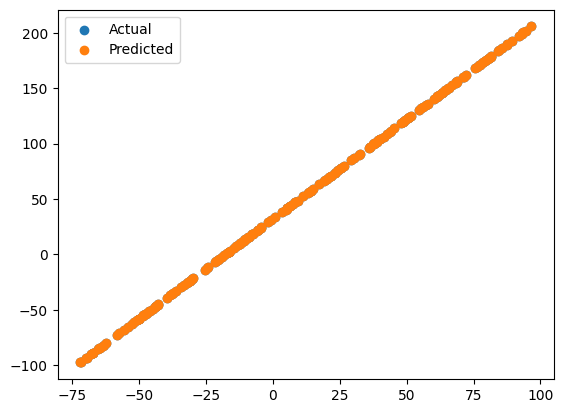

In [7]:
# Plot training and validation loss and MAE
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Predict and plot predictions against actual values
print("Let's make a prediction!")
predictions = model.predict(X_val)
plt.scatter(X_val, y_val, label='Actual')
plt.scatter(X_val, predictions, label='Predicted')
plt.legend()
plt.show()

# Save the model
model.save('./models/temperature_model.keras')

# Save and export

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1_20240506_19  (None, 3)                 6         
 2645_823030 (Dense)                                             
                                                                 
 hidden_layer_2_20240506_19  (None, 3)                 12        
 2645_825399 (Dense)                                             
                                                                 
 output_layer_20240506_1926  (None, 1)                 4         
 45_825692 (Dense)                                               
                                                                 
Total params: 22 (88.00 Byte)
Trainable params: 22 (88.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


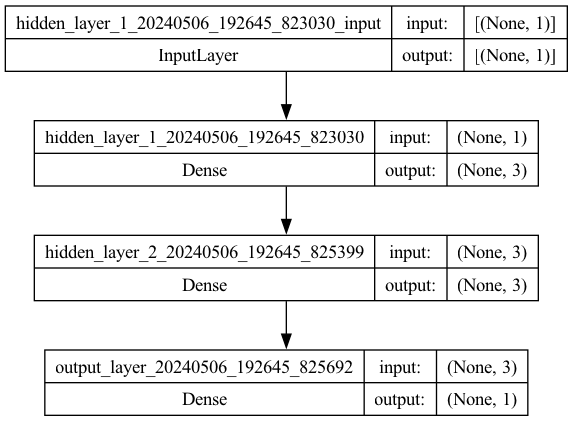

In [8]:
# Plotting the model architecture
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [9]:
!tensorflowjs_converter --input_format=keras_saved_model --output_format=tfjs_layers_model ./models/temperature_model.keras ./models/js_model

/Users/montevideo/anaconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/Users/montevideo/code/ThermalTensorFlowJS/ThermalTensorFlowJS/lib/python3.11/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-05-06 19:27:03.789173: W tensorflow/c/c_api.cc:305] Operation '{name:'hidden_layer_2_20240506_192645_825399/bias/Assign' id:43 op device:{requested: '', assigned: ''} def:{{{node hidden_layer_2_20240506_192645_825399/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](hidden_layer_2_20240506_192645_825399/bias, hidden_layer_2_20240506_192645_825399/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n